In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pandas.io.data as web
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

from tempfile import NamedTemporaryFile
from IPython.display import HTML
from matplotlib import animation

import zipline
from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol, history

import pytz
from datetime import datetime

%matplotlib inline

/Users/sy/Dropbox/FinEng/Jupyter/jup1/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


## Preface: casual discussion

Again and again, we use equations with the following form:
$$ dp_t = a(t, p_t) dt +  b(t, p_t) dW_t $$

This is called Stochastic Differential Equation (SDE).  

The first part 
$$ dp_t = a(t, p_t) dt $$
is a differential equation we are familiar with. We call this Deterministic part.  It may look more familiar in the form:
$$ \frac{dp}{dt} = a(t, p_t) $$
We often want to understand $p_t$ by observing its rate of change over time $t$.

Now the second part
$$ b(t, p_t) dW_t $$
represnets the Stochastic part.  We won't be able to grasp SDE right away. For now, we think of Stochastic Calculus (that contains SDE) as Calculus where variables are random variables. 
Here $W_t$ is probabilistic random variable.  In literature, we often see terms 'Brownian', 'Random', 'Stochastic' used interchangably to refer to $dW_t$ part.


Q: So why SDE for pairt trading?

A: Mean reversion is modelled using Orstein-Uhlenbeck SDE model, and cointegration testing uses a discrete version of OU model

Now OU model SDE is:
$$ dp_t = -\rho (p_t - \mu) dt + \sigma dW_t $$
(I previously used 
$d p_t = k(\mu - p_t) dt + \sigma dW_t $
I tried to follow most common convention).

In OU model, the deterministic part is
$$ \frac{dp}{dt} = -\rho (p_t - \mu)$$
$p_t - \mu$ represents displacement of $p_t$ from the mean $\mu$ to which it will revert back.
One way to think of it is that velocity $\frac{dp}{dt}$ is proportional to the displacement from the mean (that makes sense). And $-\rho$ is the proportion constant.  Of course, it does not have to be constant, it can vary with time. But it makes things simpler when we assume $-\rho$ is constant at least a certain period.

Now the stochastic part:
$$ \sigma dW_t $$
Here $W_t$ is stochastic variable we use to model 'news', 'shock', or 'uncertainty' part of $p_t$ behaviour.  Even if, $p_t$ revert back to its mean, it will be bumpy with uncertainty and we want to incorporate that into our model.

Q: what is $\sigma$ then?

A: We have to interpret $\frac{dp_t}{dW_t}$ in Stochastic context which we cannot do here. For now, we can think of $\sigma$ as some sort of "regulator."   Volatility or variance is a good choice for $\sigma$.

Possible Answer for comments questions: 

- More detailed discussion and discretization of OU model follows below.

- Definitions of 'Brownian motion', 'Random Walk' are somewhat informal and they seem to vary depending on context. The reason is that we can used different models to describe them.  As we start to deal with volatility model, we will need to be more precise and use more specific term like Wiener process that has a clear definition.

- When we write 
$$ p_t = \gamma p_{t-1} + \dots $$
$p_t$ seem to depend on $p_{t-1}$.  It surely does.  But what we are interested is its change:
$$ \Delta p_t = p_t -p_{t-1} = (\gamma-1) p_{t-1} + \dots $$
So when $\gamma =1$, $\Delta p_t$ is independt of $p_{t-1}$ The result is 'random walk' as $\Delta p_t$ only depends on stochastic part.

- I made up term DMW. I should not use it, it is too informal.


# Pair Trading

Find cointegrated pair $X_t, Y_t$: Do linear regression $Y_t = m X_t$ for some $m$ so that $Y_t - m X_t$ is stationary.

The main reason we are interested in $Y_t - m X_t$ being stationary is that it becomes mean reverting.

## Mean Reverting Process

For mean reverting process we use well known Diffusion Process model from Stochastic Differential Equations:
$$ dp_t = a(t, p_t) dt +  b(t, p_t) dW_t $$

Among diffusion process, we use Orstein-Uhlenbeck process in particualar. In terms of its use in pair trading, we will model $Y_t - mX_t$ as a discretized OU process. Then we apply Dickey-Fuller test to show this discretized OU process is indeed stationary (mean reverting).

First, contemplate OU model:

### Orstein-Uhlenbeck Model

OU process is a stochastic process that follows
$$ dp_t = -\rho (p_t - \mu) dt + \sigma dW_t $$

Consider this in form
$$ \frac{d p_t}{dt} = -\rho (p_t - \mu)  + \dots $$
That is, the rate of price change $\frac{d p_t}{dt}$ is proportial to displacement $(p_t - \mu)$

Also note that $-\rho< 0$, that is, the direction of the movement of $p_t$ is the opposite of displacement.

Fourtunately, we can find a closed form solution to OU model:

$$p_t = \mu + e^{-\rho t}(p_0 - \mu) + \sigma \int_0^t e^{-\rho (t-u)} \ dW_u $$
(Here the second term on LHS is Ito integral).

Now we make some observations:
- Note that as $t \rightarrow \infty$, $\ p_t \rightarrow \mu$: That is, it is mean reverting
- One reference of interest is the half life. We start from initial $p_0$ then revert back to its eventual mean $\mu$. And we are interested in finding time takes to reach the midpoint $\frac{p_0 + \mu}{2}$

We can compute the half life by solving
$$ 
\begin{eqnarray*}
\frac{p_0 + \mu}{2} & = &\mu + e^{-\rho t}(p_0 - \mu)   \\
t & = & \frac{\ln 2 }{\rho} 
\end{eqnarray*} 
$$

Next, we need to discretize OU process for numerical simulation.  One of the most common way is Euler-Murayama:

### Discretization: Euler-Murayama

We set OU model into more general SDE form:
$$ dp_t = a(t, p_t) dt +  b(t, p_t) dW_t  $$

For example we can use  Euler-Maruyama discretization of OU process into AR(1) process:
First consider OU process equation as a recursive construction:
$$ p_{t+1} = p_{t} +  a(p_{t}) \Delta t + b(p_{t}) \Delta W_{t} $$
That is,
$$
\begin{eqnarray*}
a(p_{t}) \Delta t + b(p_{t}) \Delta W_{t-1} & \approx & -\rho (p_t - \mu) dt + \sigma dW_t \\
\text{where}\ \ a(p_{t}) & = &  -\rho (p_t - \mu) \\
 b(p_{t})  & = & \sigma \\
\end{eqnarray*}
$$
Next we can set
$$ \sigma \Delta W_t =   \sigma \epsilon_t  \sqrt{\Delta t} $$
(We will not dwell on why $\sqrt{\Delta t}$ An interesting explanation is from Einstein's theory of Brownian motion.)

#### Example [Generated OU model]

Half Life: 0.990210257943


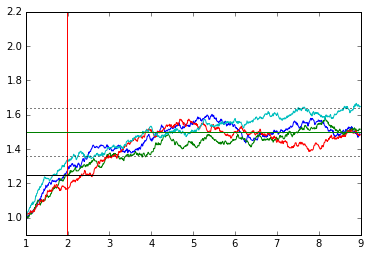

In [49]:
num_sims = 4
N        = 1000

y_init = 1.0
t_init = 1
t_end  = 9

c_rho = 0.7
c_mu    = 1.5
c_sigma = 0.06

def mu(y, t): 
    return -c_rho * (y - c_mu)
        
def sigma(y, t): 
    return c_sigma

dt   = float(t_end - t_init) / N
dW   = lambda dt: np.random.normal(loc = 0.0, scale = np.sqrt(dt))

t    = np.arange(t_init, t_end, dt)
y    = np.zeros(N)
y[0] = y_init

for i_sim in range(num_sims):
    for i in xrange(1, t.size):
        a = mu(y[i-1], (i-1) * dt)
        b = sigma(y[i-1], (i-1) * dt)
        y[i] = y[i-1] + a * dt + b * dW(dt)
    plt.plot(t, y)

hL= np.log(2)/c_rho
print 'Half Life:', hL

std = np.sqrt(y.var())
#print 'std:', std

plt.ylim([0.9,2.2])
plt.axvline(hL+t_init, c='r')
plt.axhline((y_init+c_mu)/2, c='k') #midway between p_0 and mu
plt.axhline(c_mu, c='g')
plt.axhline(c_mu+std, c='k', ls='dotted')
plt.axhline(c_mu-std, c='k', ls='dotted')


This generated example convinces us the OU is reasonable model for mean reverting behaviour.

Now given a candidate pair $(Y_t, X_t)$, we do linear regression and we want to show stationarity.  The common tool is Dickey-Fuller test:

### Dickey-Fuller: Unit Root Test 

To see the morale behind DF test, we examine discretization of OU model:
Recall Euler-Murayama discretization of OU model:

$$
\begin{eqnarray*}
d p_t & = & -\rho (p_t - \mu) dt + \sigma dW_t \\
p_{t+1} & = & p_t + a(p_{t}) \Delta t + b(p_{t}) \Delta W_{t}  \\
p_{t+1} & = & p_t -\rho (p_t - \mu) \Delta t + \sigma \Delta W_{t} \\
p_{t+1} & = &  (1- \rho \Delta t)  p_t + \rho \mu \Delta t + \sigma \sqrt{\Delta t}\  \epsilon_{t} \\
p_{t+1} & = &  \gamma  p_t + \rho \mu \Delta t + \sigma \sqrt{\Delta t}\  \epsilon_{t} \\
 & \text{or} & \\
\Delta p_{t+1} & = & (\gamma-1)  p_t + \rho \mu \Delta t + \sigma \sqrt{\Delta t}\  \epsilon_{t} \\
\end{eqnarray*}
$$

DF test examines if $\gamma$ is a unit root. If $\gamma =1$ then the increment of $p_t$ is 
Brownian in nature and it is not stationary:
$$ \Delta p = \rho \mu \Delta t + \sigma \sqrt{\Delta t}\  \epsilon_{t}$$


In DF test, the null hypothesis is that $\gamma=1$: process is not stationary.
Just as in any other hypothesis testing, we obtain a statistic and find its p-score.
In DF test, this statistic is
$$ DFS = \frac{\hat{\gamma} - 1}{s.e.(\hat{\gamma}) } $$
According to DF, $DFS$ does not follow normal or Student's t distributions.   
We  need to test $DFS$ against a simulated ditribution table, and the lastest one is by Mackinnon.

In [27]:
# mostly taken from statsmodels 'coint', 'adfuller' method
def produce_DF_stat(X, Y):
    
    # find Y-mX
    p_t = sm.OLS(Y, X).fit().resid   
    p_t_lag = sm.add_constant(p_t[0:-1], prepend=False) #p_{t-1}
    
    # DF test: unit root regression with p_t and p_{t-1}
    uroot_reg = sm.OLS(p_t[1:], p_t_lag).fit() 
    
    # see the formula above
    gamma_hat = uroot_reg.params[0] # later, this will be used to find the half life 
    ste_gamma_hat = uroot_reg.bse[0]
    DFS = (gamma_hat - 1) / ste_gamma_hat # DF statistic
    
    return DFS, gamma_hat

Under python statsmodels library, these steps are automated by coint method.

## Pair trading entry-exit strategy

Note: We try pair trading on intraday with minute data.

Once we decide $Z_t = Y_t - m X_t$ is mean reverting, we compute its mean, standard deviation.

Now our assumption is the fluctuation of $Z_t$ follows Gaussian. So we find z-score and decide entry-exit points based on z-scores.

The key assumption in pair trading is that pair $(X,Y)$ is cointegrated for a period so that its residual $Z_t = Y - m X_t$ is stationary for that period: in particular, a constant mean and a deviation. 

To compute stats such as mean, deviation, z-score, we typically need to decide a trailing window for $Z_t$. 

Q: What is appropriate traling window?

A: Once 'dynamics of cointegration' of the pair is well understood, we estimate the half life. The multiples of half life are good candidates for this window. 


### Suggested Task: Dynamics of Cointegration

We make an easy to use widget to investigate dynamics of cointegration.  For example, we input a pair and varies trailing window.  Then observe dynamics of cointegration: how p-values of cointegration evolve and cluster.

c.f. Pair Trading Study 2